In [1]:
# Import Statements

%matplotlib inline
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import torchsample
from torchsample import transforms as ts_transforms
import matplotlib.pyplot as plt
import time
import copy
import os
from PIL import Image
from tensorboardX import SummaryWriter
from datetime import datetime
import importlib

#from torchsample.transforms import RangeNorm

import functions.fine_tune as ft

plt.ion()   # interactive mode

## 1 - Load Data

Before running the code, the data should be downloaded and foldered in the way that is usable for imagefolder function of the PyTorch. The following code assumes that the main directory for the dataset is 'data_dir' and it includes subdirectories for all of the separate classes.

For details on how to create those folders, pleaserefer to 'dataset/Folder_images.ipynb'

In [2]:
# Data augmentation and normalization for training 
# Just normalization for validation
dataset_both=False
dataset='real'
uniform_sampler=False
batch_size=16

'''Will be pruned'''
split=1000
random_seed=1
shuffle=True

data_transforms = {
    'train': transforms.Compose([
        transforms.Scale(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        #ts_transforms.RandomRotate(30)
    ]),
    'val': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

if(dataset=='real'):
    data_dir = '/home/mtezcan/Documents/Hoarding/Data_Sets/pruned/good'
    dsets = {x: datasets.ImageFolder_mtezcan([os.path.join(data_dir, x)], data_transforms[x])
             for x in ['train', 'val']}
    dsets_real = dsets
    
if(dataset=='mit_indoor'):
    data_dir = '..//Data_Sets//MIT_indoor_scenes'
    dsets = {x: datasets.ImageFolder_mtezcan([os.path.join(data_dir, x)], data_transforms[x])
             for x in ['train', 'val']}
    dsets_real = dsets
    
if(dataset=='synthetic'):
    rootdir='//media//mtezcan//New Volume/HoardingImages//_rated//'
    valdir='//media//mtezcan//New Volume/HoardingImages//_val//validation//House//'
    #subdirs=os.listdir(rootdir)
    subdirs = ['BasicHouse_2017-07-01-rated',
               'BriansHouse_2017-06-30-rated',
               'RuralHome_2017-06-30-rated',
               'SmallApt_2017-06-29-rated']
    roomdirs=['//BR','//Kitchen','//LR']
    '''
    rootdir='//media//mtezcan//New Volume/HoardingImages//_rated//train//'
    valdir='//media//mtezcan//New Volume/HoardingImages//_rated//val//BriansHouse_2017-06-30-rated//LR//'
    subdirs=['BriansHouse_2017-06-30-rated']
    print(subdirs)
    roomdirs=['//LR']
    '''
    dsets = {'train':datasets.ImageFolder_mtezcan([rootdir+subdir+room for subdir in subdirs
                                                   for room in roomdirs], data_transforms['train']),
             'val':datasets.ImageFolder_mtezcan([valdir+room for room in roomdirs], data_transforms['val'])}
 
if(uniform_sampler):
    weights,wpc = ft.make_weights_for_balanced_classes(dsets['train'].imgs, len(dsets['train'].classes))  
    weights = torch.DoubleTensor(weights) 
    sampler = {'train':torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights)) ,
               'val':None}
else:
    sampler = {'train':None,
               'val':None}

shuffler={'train':True,'val':False}
dset_loaders = {x:torch.utils.data.DataLoader(dsets[x], batch_size=batch_size,shuffle=shuffler[x],sampler=sampler[x], num_workers=12)
                for x in ['train','val']}
dset_sizes = {x: len(dsets[x]) for x in ['train', 'val']}
dset_classes = dsets['train'].classes
print(dset_classes)
use_gpu = torch.cuda.is_available()

if(dataset=='real'):
    dset_loaders_real=dset_loaders
    dset_sizes_real=dset_sizes
elif(dataset=='synthetic'):
    dset_loaders_synthetic=dset_loaders
    dset_sizes_synthetic=dset_sizes
#use_gpu=False
if use_gpu:
    print('GPU is available')
else:
    print('!!!!! NO CUDA GPUS DETECTED')

768
768
329
329
['1', '2', '3', '4', '5', '6', '7', '8', '9']
GPU is available


In [2]:
'''
Macros
'''
#uniform_sampler=False
batch_size=64
split=1000
random_seed=1
shuffle=True

# Data augmentation and normalization for training 
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Scale(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        #ts_transforms.RandomRotate(30)
    ]),
    'val': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


'''Create ImageFolder objects for training and test'''
data_dir = '../images/0to5'
#data_dir = '/home/mtezcan/Documents/amazon/bin_images/0to5'
dset_train = datasets.ImageFolder(data_dir, data_transforms['train'])
dset_val = datasets.ImageFolder(data_dir, data_transforms['val'])

'''Validation split'''
num_train = len(dset_train)
indices = list(range(num_train))
val_idx=np.loadtxt('./dataset/random_val.txt').astype(np.int)
train_idx=np.setdiff1d(indices,val_idx)

'''if shuffle == True:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
    train_idx, val_idx = indices[split:], indices[:split]'''

'''Sampler functions for validation and training'''
sampler_train = torch.utils.data.sampler.SubsetRandomSampler(train_idx)
sampler_val = torch.utils.data.sampler.SubsetRandomSampler(val_idx)

'''Define dataset loaders'''
dset_loaders = {'train':torch.utils.data.DataLoader(dset_train, batch_size=batch_size,sampler=sampler_train,
                                                    num_workers=12),
                'val':torch.utils.data.DataLoader(dset_val, batch_size=batch_size,sampler=sampler_val,
                                                    num_workers=12)}


dset_sizes={'train':len(dset_train)-1000,'val':1000}
dset_classes = dset_train.classes
use_gpu = torch.cuda.is_available()

print('Number of training images '+str(len(train_idx)))
print('Number of validation images '+str(len(val_idx)))

if use_gpu:
    print('GPU is available')
else:
    print('!!!!! NO CUDA GPUS DETECTED')

NameError: name 'num_train' is not defined

Let's visualize a few training images so as to understand the data
augmentations.



Size of the input tensors in one batch after grid is  torch.Size([3, 1810, 1810])


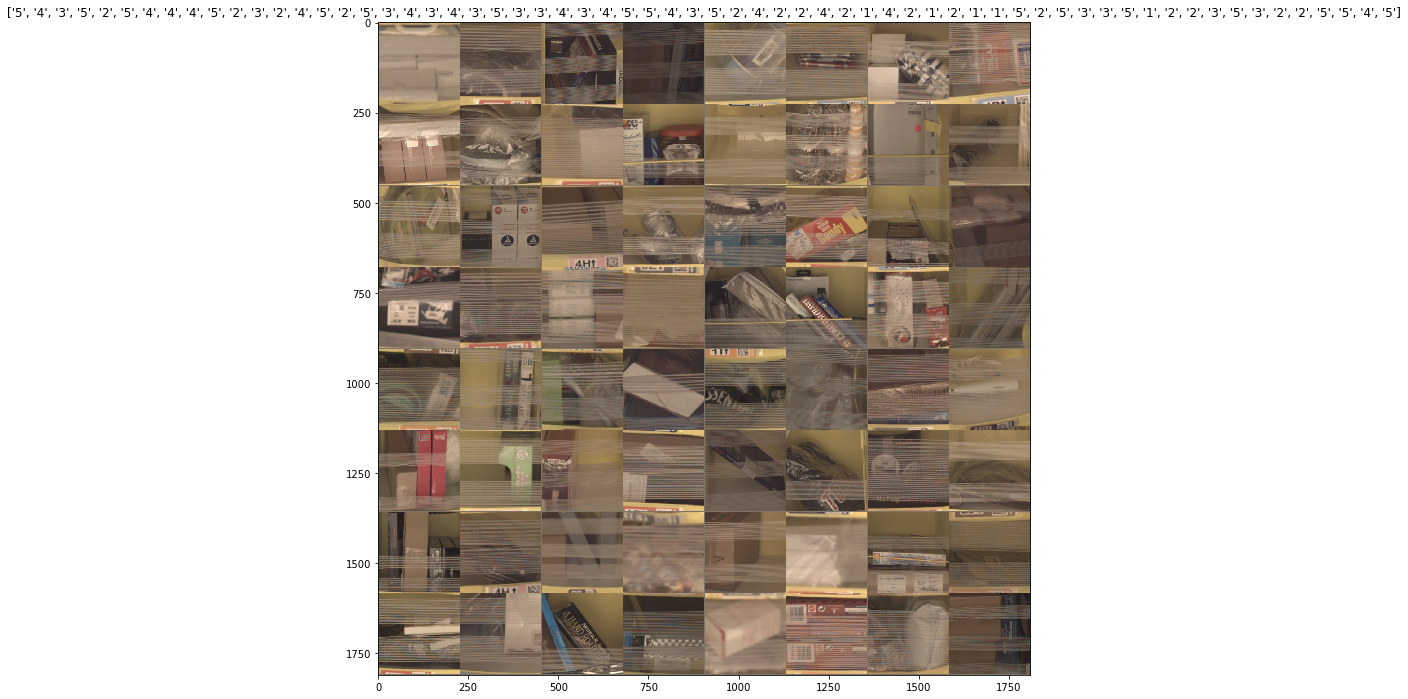

In [4]:
inputs, classes = next(iter(dset_loaders['val']))
out = torchvision.utils.make_grid(inputs,nrow=8)
print('Size of the input tensors in one batch after grid is  '+str(out.size()))
plt.figure(figsize=(12,12))
ft.imshow(out, title=[dset_classes[x] for x in classes])

## 2- Log Keeping

This section includes the functions defined for the log keeping. Since CNNs require lots of trials, I found it easy to record the properties of the each trial with their performances in an excel file. I also added tnesorboard summaries for every trial and individual text files for showing the details of the network.

Below code declares the required parameters for the network which will be also used inside log keeping

In [5]:
network='resnet34' #Initial network archtiecture.'loaded'forusing a saved network
networkName='resnet18_real_sgd_multisoft_August29  19:06:27' #Directory for the saved network
optimizer='sgd' #Optimizer function
iter_loc=14 #Number of the first column in the excel file for writing the results.
end_to_end=True #Booolean to decide whether to train the network end-to-end or not.
lr=0.01 #Initial learning rate
momentum=0.9
weight_decay=0.0005
lr_scheduler=ft.exp_lr_scheduler #Learning rate scheduler
lr_decay_epoch=10 #Number of epoch for learning rate decay
pretrained=True 
mse_loss=False #Scalar MSE loss
nclasses=6 #Number of output classes

'''Multipliers for loss functions'''
single_loss=1.
multi_loss=0.

comment=' ' #Additional comments if any

Let us define the functions for creating a text file and adding networkproperties to an excel file. 

In [6]:
def writeLog(logname):
    '''
    Creates a text file named Network_properties.txt inside runs/'logname'
    '''
    f=open('runs/'+logname+'/Network_properties.txt','w')
    f.write('Batch size: '+str(batch_size)+'\n')
    f.write('Validation size: '+str(split)+'\n')
    f.write('Random seed: '+str(random_seed)+'\n')
    f.write('Shuffle: '+str(shuffle)+'\n')
    f.write('Validation size: '+str(split)+'\n')
    f.write('Network: '+network+'\n')
    if mse_loss:
        crt='MSE'
    else:
        crt=str(single_loss)+'xsingle + '+str(multi_loss)+'Xmulti'
    f.write('Criterion: '+crt+'\n')
    f.write('Learning rate: '+str(lr)+'\n')
    f.write('Momentum: '+str(momentum)+'\n')
    f.write('Leraning Rate Scheduler: '+str(lr_scheduler)+'\n')
    f.write('Leraning Rate Decay Period: '+str(lr_decay_epoch)+'\n')
    f.write('Network is pretrained: '+str(pretrained)+'\n')
    f.write('Network laoded from: '+networkName+'\n')
    f.write('MSE loss function: '+str(mse_loss)+'\n')
    f.close()

In [7]:
import openpyxl
import time

def writeLog_xlsx(logname='logs.xlsx',iter_loc=14):
    '''
    Adds a line to logs.xlsx with the network properties and outcomes.
    :param iter_loc: First column to record the outcomes.
    '''
    book = openpyxl.load_workbook(logname)
    sheet = book.active
    if mse_loss:
        crt='MSE'
    else:
        crt=str(single_loss)+'xsingle + '+str(multi_loss)+'Xmulti'
    if network=='loaded':
        specs=(datetime.now().strftime('%B%d  %H:%M:%S'),networkName,str(split),str(random_seed),str(shuffle),
               optimizer, crt,str(lr),str(momentum),str(lr_scheduler),str(lr_decay_epoch),str(pretrained),
               str(batch_size))
    else:
        specs=(datetime.now().strftime('%B%d  %H:%M:%S'),network,str(split),str(random_seed),str(shuffle),
               optimizer, crt,str(lr),str(momentum),str(lr_scheduler),str(lr_decay_epoch),str(pretrained),
               str(batch_size))
    sheet.append(specs)
    current_row = sheet.max_row
    sheet.cell(row=current_row, column=iter_loc+5).value = comment
    book.save(logname)

## 3 - Training and Validation

In this part we will define the functions for training a CNN with different properties and loss functions.

The following function takes bunch of properties defined in the beginning of Section-2 as input and creates network using those properties.

In [8]:
model_ft = models.resnet34(pretrained=pretrained)
num_ftrs = model_ft.fc.in_features
print(nclasses)
model_ft.fc = nn.Linear(num_ftrs, nclasses)

6


In [9]:
def network_loader(comment=comment,
                    network=network,
                    networkName=networkName,
                    optimizer=optimizer,
                    iter_loc=iter_loc,
                    end_to_end=end_to_end,
                    lr=lr,
                    momentum=momentum,
                    weight_decay=weight_decay,
                    lr_scheduler=lr_scheduler,
                    lr_decay_epoch=lr_decay_epoch,
                    pretrained=pretrained,
                    mse_loss=mse_loss,
                    nclasses=nclasses):
    
    '''Load the network from pytorch'''
    if(network=='resnet18'):
        model_ft = models.resnet18(pretrained=pretrained)
        if not end_to_end:
            for param in model_ft.parameters():
                param.requires_grad = False 
        num_ftrs = model_ft.fc.in_features #Change the last layer to adapt new classes
        if(mse_loss): #For MSE loss last layer should be a scalar
            model_ft.fc = nn.Linear(num_ftrs, 1)
        else:    
            model_ft.fc = nn.Linear(num_ftrs, nclasses)
    elif(network=='resnet34'):
        model_ft = models.resnet34(pretrained=pretrained)
        if not end_to_end:
            for param in model_ft.parameters():
                param.requires_grad = False 
        num_ftrs = model_ft.fc.in_features
        if(mse_loss):
            model_ft.fc = nn.Linear(num_ftrs, 1)
        else:    
            model_ft.fc = nn.Linear(num_ftrs, nclasses)
    elif(network=='resnet50'):
        model_ft = models.resnet50(pretrained=pretrained)
        if not end_to_end:
            for param in model_ft.parameters():
                param.requires_grad = False 
        num_ftrs = model_ft.fc.in_features
        if(mse_loss):
            model_ft.fc = nn.Linear(num_ftrs, 1)
        else:    
            model_ft.fc = nn.Linear(num_ftrs, nclasses)
    elif(network=='resnet101'):
        model_ft = models.resnet101(pretrained=pretrained)
        if not end_to_end:
            for param in model_ft.parameters():
                param.requires_grad = False 
        num_ftrs = model_ft.fc.in_features
        if(mse_loss):
            model_ft.fc = nn.Linear(num_ftrs, 1)
        else:    
            model_ft.fc = nn.Linear(num_ftrs, nclasses)
    elif(network=='alexnet'):
        model_ft = models.alexnet(pretrained=pretrained)
        num_ftrs = model_ft.classifier[6].out_features
        setattr(model_ft.classifier, '7', nn.ReLU(inplace=True))
        setattr(model_ft.classifier, '8', nn.Dropout())
        setattr(model_ft.classifier, '9', nn.Linear(num_ftrs,nclasses))

    elif(network=='loaded'):#Use the saved network when network='loaded'
        model_ft = torch.load('./saved_models/'+networkName)
        if not end_to_end:
            for param in model_ft.parameters():
                param.requires_grad = False 
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, nclasses)
    else:
        raise ValueError('Undefined network '+network)

    if use_gpu:
        model_ft = model_ft.cuda()

    '''Define the optimizer function'''
    if(optimizer=='adam'):
        optimizer_ft = optim.Adam(model_ft.parameters(),lr=lr,weight_decay=weight_decay)
    elif(optimizer=='sgd'):
        if(end_to_end):
            optimizer_ft = optim.SGD(model_ft.parameters(), lr=lr, momentum=momentum)
        else:
            optimizer_ft = optim.SGD(model_ft.fc.parameters(), lr=lr, momentum=momentum,weight_decay=weight_decay)
    return model_ft, optimizer_ft

Now define a simple function to be able to run our training in a single line

In [10]:
importlib.reload(ft)

def run_network():
    '''
    Cretaes the log files and starts the training
    '''
    model_ft, optimizer_ft = network_loader(comment=comment, #'Tested for three rooms'
                                            network=network,
                                            networkName=networkName,
                                            optimizer=optimizer,
                                            iter_loc=iter_loc,
                                            end_to_end=end_to_end,
                                            lr=lr,
                                            momentum=momentum,
                                            weight_decay=weight_decay,
                                            lr_scheduler=lr_scheduler,
                                            lr_decay_epoch=lr_decay_epoch,
                                            pretrained=pretrained,
                                            mse_loss=mse_loss,
                                            nclasses=nclasses)
    
    '''Name of the trial'''
    if mse_loss:
        crt='MSE'
    else:
        crt=str(single_loss)+'xsingle + '+str(multi_loss)+'Xmulti'
    logname=network+'_'+'_'+optimizer+'_'+crt+'_'+datetime.now().strftime('%B%d  %H:%M:%S')
    writer = SummaryWriter('runs/'+logname) #For tensorboard
    writeLog(logname)
    writeLog_xlsx()
    
    '''Start trianing'''
    best_model, last_model = ft.train_model(model_ft,optimizer_ft, lr_scheduler,dset_loaders,
                            dset_sizes,writer,use_gpu=use_gpu,num_epochs=30,batch_size=batch_size,num_log=250,
                            multi_prob=False,lr_decay_epoch=lr_decay_epoch,init_lr=lr,mse_loss=mse_loss,
                            iter_loc=iter_loc,cross_loss=single_loss,multi_loss=multi_loss,numOut=nclasses)
    
    '''Save the models'''
    torch.save(best_model,'./saved_models/'+logname+'_best')
    torch.save(last_model,'./saved_models/'+logname+'_last')
    
    '''Frre up the memory'''
    del model_ft


## 4 - Trials

The loss function we used in the experiments is the following,

$$loss(\mathbf{y},\hat{y})=(1-\lambda )loss_{single}(\mathbf{y},\hat{y})+\lambda loss_{multi}(\mathbf{y},\hat{y})$$
where $\mathbf{y}$ is the ground truth and $\hat{y}$ is the prediction.

Now lets test our function for different values of $\lambda$.

In [11]:
single_loss=1.
multi_loss=0.

run_network()

Epoch 0/29
----------
LR is set to 0.01
250/5641, acc: 0.3030, CIR-1: 0.7361, RMSE: 1.3696
500/5641, acc: 0.3271, CIR-1: 0.7677, RMSE: 1.2966
750/5641, acc: 0.3425, CIR-1: 0.7815, RMSE: 1.2604
1000/5641, acc: 0.3495, CIR-1: 0.7890, RMSE: 1.2422
1250/5641, acc: 0.3588, CIR-1: 0.7981, RMSE: 1.2194
1500/5641, acc: 0.3643, CIR-1: 0.8038, RMSE: 1.2048
1750/5641, acc: 0.3697, CIR-1: 0.8088, RMSE: 1.1928
2000/5641, acc: 0.3744, CIR-1: 0.8124, RMSE: 1.1823
2250/5641, acc: 0.3788, CIR-1: 0.8166, RMSE: 1.1719
2500/5641, acc: 0.3822, CIR-1: 0.8190, RMSE: 1.1650
2750/5641, acc: 0.3848, CIR-1: 0.8221, RMSE: 1.1573
3000/5641, acc: 0.3872, CIR-1: 0.8243, RMSE: 1.1524
3250/5641, acc: 0.3899, CIR-1: 0.8262, RMSE: 1.1469
3500/5641, acc: 0.3927, CIR-1: 0.8285, RMSE: 1.1409
3750/5641, acc: 0.3948, CIR-1: 0.8306, RMSE: 1.1356
4000/5641, acc: 0.3969, CIR-1: 0.8324, RMSE: 1.1308
4250/5641, acc: 0.3986, CIR-1: 0.8338, RMSE: 1.1268
4500/5641, acc: 0.4000, CIR-1: 0.8350, RMSE: 1.1236
4750/5641, acc: 0.4017, CIR

Process Process-687:
  File "/home/mtezcan/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Process Process-685:
Process Process-693:
Process Process-690:
Process Process-688:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mtezcan/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/mtezcan/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/mtezcan/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/mtezcan/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/mtezcan/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self

KeyboardInterrupt: 

In [ ]:
mse_loss=False
for lmbda in [0., 0.7, 1.]:
    single_loss=1.-lmbda
    multi_loss = lmbda
run_network()